In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product
import h5py

import gym
import numpy as np
import matplotlib
import matplotlib.cm
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv
from stable_baselines3.common.vec_env import VecTransposeImage

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

In [2]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [49]:
env_id = "BreakoutNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 3
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [50]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


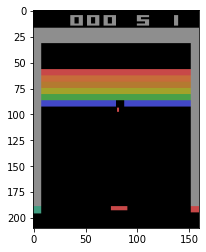

In [51]:
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0]:
        break
plt.imshow(env.render(mode='rgb_array'))

0
50
100
150
200
250
300
350
400
450


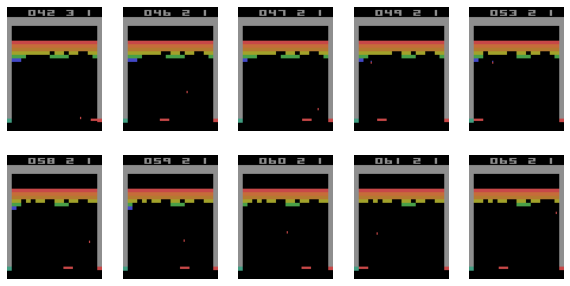

In [32]:
plt.figure(figsize=(10, 5))

n = 1

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if i % 50 == 0 and n <= 10:
        print(i)
        frame = env.render(mode='rgb_array')
        plt.subplot(2, 5, n)
        plt.imshow(frame)
        plt.axis('off')
        n += 1
    
    
plt.savefig('presentation/breakout_tenframes_render.png', dpi=300, bbox_inches='tight')

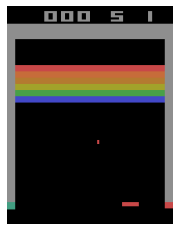

In [24]:
plt.imshow(env.render(mode='rgb_array'))
plt.axis('off')
plt.savefig('presentation/breakout_singleframe_render.png', dpi=300, bbox_inches='tight')

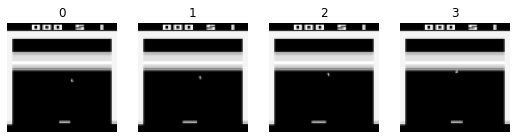

In [52]:
plt.figure(figsize=(9, 3))
for k in range(4):
    plt.subplot(1, 4, k+1)
    plt.imshow(obs[0, :, :, k], cmap='gray')
    plt.axis('off')
    plt.title(k)

# plt.savefig('presentation/breakout_framestack.png', dpi=300, bbox_inches='tight')

In [53]:
def get_mask(center, size, r):
    y,x = np.ogrid[-center[0]:size[0]-center[0], -center[1]:size[1]-center[1]]
    keep = x*x + y*y <= 1
    mask = np.zeros(size) ; mask[keep] = 1 # select a circle of pixels
    mask = scipy.ndimage.gaussian_filter(mask, sigma=r) # blur the circle of pixels. this is a 2D Gaussian for r=r^2=1
    return mask/mask.max()

def occlude(img, mask):
    assert img.shape[1:] == (84, 84, 4)
    img = np.copy(img)
    for k in range(4):
        I = img[0, :, :, k]
        img[0, :, :, k] = I*(1-mask) + scipy.ndimage.gaussian_filter(I, sigma=3)*mask
    return img

In [55]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

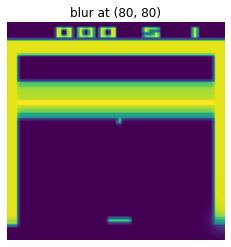

In [59]:
stride = 5
radius = 5

TIMESTEPS = 150

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"occlusion demo", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=28, metadata=metadata)

fig, ax = plt.subplots(1, 1)
ax.axis('off')

imshow = ax.imshow(obs[0, :, :, 3])

with writer.saving(fig, "presentation/breakout_occlusion_demo.mp4", dpi=200):
    for i in range(0, 84, stride):
        for j in range(0, 84, stride):
            mask = get_mask(center=(i, j), size=(84, 84), r=radius)
            obs_perturbed = occlude(obs, mask)
            imshow.set_data(obs_perturbed[0, :, :, 3])
            ax.set_title(f"blur at ({i}, {j})")
            writer.grab_frame()


In [6]:
def get_mask(center, size, r):
    y,x = np.ogrid[-center[0]:size[0]-center[0], -center[1]:size[1]-center[1]]
    keep = x*x + y*y <= 1
    mask = np.zeros(size) ; mask[keep] = 1 # select a circle of pixels
    mask = scipy.ndimage.gaussian_filter(mask, sigma=r) # blur the circle of pixels. this is a 2D Gaussian for r=r^2=1
    return mask/mask.max()

In [7]:
def occlude(img, mask):
    assert img.shape[1:] == (84, 84, 4)
    img = np.copy(img)
    for k in range(4):
        I = img[0, :, :, k]
        img[0, :, :, k] = I*(1-mask) + scipy.ndimage.gaussian_filter(I, sigma=3)*mask
    return img

In [15]:
def compute_saliency_map(reward_model, obs, stride=5, radius=5):
    baseline = reward_model(obs).detach().cpu().numpy()
    scores = np.zeros((84 // stride + 1, 84 // stride + 1))
    for i in range(0, 84, stride):
        for j in range(0, 84, stride):
            mask = get_mask(center=(i, j), size=(84, 84), r=radius)
            obs_perturbed = occlude(obs, mask)
            perturbed_reward = reward_model(obs_perturbed).detach().cpu().numpy()
            scores[i // stride, j // stride] = 0.5 * np.abs(perturbed_reward - baseline) ** 2
    pmax = scores.max()
    scores = skimage.transform.resize(scores, output_shape=(210, 160))
    scores = scores.astype(np.float32)
#     return pmax * scores / scores.max()
    return scores / scores.max()

In [29]:
def add_saliency_to_frame(frame, saliency, channel=1):
#     def saliency_on_atari_frame(saliency, atari, fudge_factor, channel=2, sigma=0):
    # sometimes saliency maps are a bit clearer if you blur them
    # slightly...sigma adjusts the radius of that blur
    pmax = saliency.max()
    I = frame.astype('uint16')
    I[:, :, channel] += (frame.max() * saliency).astype('uint16')
    I = I.clip(1,255).astype('uint8')
    return I

In [30]:
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        self.ac_model = ALGOS['a2c']('CnnPolicy', env).policy
        self.reward_net = nn.Linear(512, 1).to(device)
        self.device = device
    
    def forward(self, obs):
        obs_transposed = VecTransposeImage.transpose_image(obs)
        latent, _, _= self.ac_model._get_latent(th.tensor(obs_transposed).to(self.device))
        return self.reward_net(latent)
    
    def forward_tensor(self, obs):
        """obs is a tensor which has already been transposed correctly."""
        latent, _, _= self.ac_model._get_latent(obs.to(self.device))
        return self.reward_net(latent)
    
    def freeze_extractor(self):
        for p in self.ac_model.policy.features_extractor.parameters():
            p.requires_grad = False

In [31]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/breakout_rm_v1.pt"))

<All keys matched successfully>

In [32]:
sal = compute_saliency_map(rm, obs)

In [33]:
frame = env.render(mode='rgb_array')
frame = add_saliency_to_frame(frame, sal)

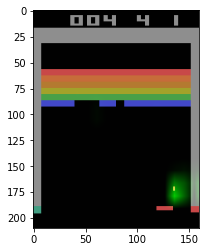

In [34]:
plt.imshow(frame)

In [35]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

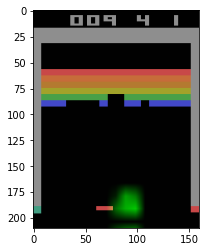

In [36]:
radius = 8
stride = 3

TIMESTEPS = 150

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=14, metadata=metadata)

fig, ax = plt.subplots(1, 1)

obs = env.reset()
imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "atariocclusion/newbreakoutrewardmodelsaliency.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
        
        sal = compute_saliency_map(rm, obs)
        screenshot = env.render(mode='rgb_array')
        image = add_saliency_to_frame(screenshot, sal)
        
        imshow.set_data(image)
        writer.grab_frame()

In [39]:
env_id = "SeaquestNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [40]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [41]:
obs = env.reset()

0
50
100
150
200
250
300
350
400
450


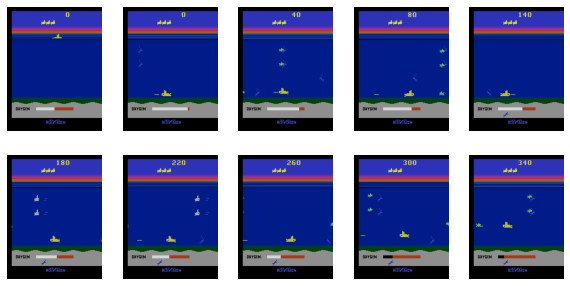

In [42]:
plt.figure(figsize=(10, 5))

n = 1

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if i % 50 == 0 and n <= 10:
        print(i)
        frame = env.render(mode='rgb_array')
        plt.subplot(2, 5, n)
        plt.imshow(frame)
        plt.axis('off')
        n += 1
    
    
plt.savefig('presentation/seaquest_tenframes_render.png', dpi=300, bbox_inches='tight')

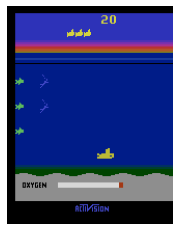

In [20]:
plt.imshow(env.render(mode='rgb_array'))
plt.axis('off')
plt.savefig('presentation/seaquest_singleframe_render.png', dpi=300, bbox_inches='tight')

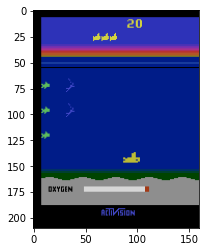

In [15]:
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0]:
        break
plt.imshow(env.render(mode='rgb_array'))

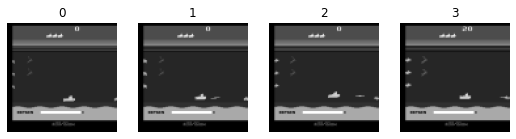

In [17]:
plt.figure(figsize=(9, 3))
for k in range(4):
    plt.subplot(1, 4, k+1)
    plt.imshow(obs[0, :, :, k], cmap='gray')
    plt.axis('off')
    plt.title(k)

plt.savefig('presentation/seaquest_framestack.png', dpi=300, bbox_inches='tight')

In [41]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/seaquest_rm_v1.pt"))

<All keys matched successfully>

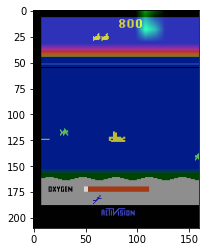

In [48]:
TIMESTEPS = 150

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=14, metadata=metadata)

fig, ax = plt.subplots(1, 1)

obs = env.reset()
imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "atariocclusion/newseaquestrewardmodelsaliency.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.reset()
        
        sal = compute_saliency_map(rm, obs, radius=5, stride=5)
        screenshot = env.render(mode='rgb_array')
        image = add_saliency_to_frame(screenshot, sal)
        
        imshow.set_data(image)
        writer.grab_frame()

In [50]:
import interp
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [52]:
no_env = gym.make('SeaquestNoFrameskipNoScore-v4')
no_env = AtariWrapper(no_env, frame_skip=1)
no_env = DummyVecEnv([lambda: no_env])
no_env = VecFrameStack(no_env, n_stack=4)

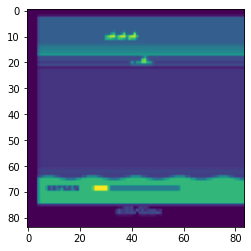

In [55]:
obs = no_env.reset()
plt.imshow(obs[0, :, :, 3])

In [79]:
obs = env.reset()
no_obs = no_env.reset()
for i in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    no_obs, no_reward, no_done, info = no_env.step(action)
    if done or no_done:
        obs = env.reset()
        no_obs = no_env.reset()
    print("True: {:1.3f} | w/ score: {:1.3f} | w/o score: {:1.3f}".format(reward[0], rm(obs).item(), rm(no_obs).item()))

    

True: 0.000 | w/ score: 0.024 | w/o score: 0.022
True: 1.000 | w/ score: 0.999 | w/o score: -0.021
True: 0.000 | w/ score: 0.012 | w/o score: -0.011
True: 0.000 | w/ score: -0.005 | w/o score: -0.010
True: 0.000 | w/ score: -0.010 | w/o score: -0.012
True: 0.000 | w/ score: 0.000 | w/o score: -0.013
True: 0.000 | w/ score: 0.055 | w/o score: -0.010
True: 0.000 | w/ score: 0.015 | w/o score: -0.010
True: 0.000 | w/ score: 0.040 | w/o score: -0.011
True: 0.000 | w/ score: -0.001 | w/o score: -0.012
True: 0.000 | w/ score: 0.007 | w/o score: -0.012
True: 0.000 | w/ score: 0.003 | w/o score: -0.012
True: 0.000 | w/ score: 0.001 | w/o score: -0.012
True: 0.000 | w/ score: 0.004 | w/o score: -0.014
True: 0.000 | w/ score: -0.005 | w/o score: -0.013
True: 0.000 | w/ score: 0.003 | w/o score: -0.012
True: 0.000 | w/ score: -0.006 | w/o score: -0.012
True: 0.000 | w/ score: 0.003 | w/o score: -0.012
True: 0.000 | w/ score: -0.000 | w/o score: -0.012
True: 0.000 | w/ score: 0.002 | w/o score: -0

In [ ]:
env = gym.make('BreakoutNoFrameskip-v4')

In [ ]:
obs = env.reset()
plt.imshow(obs)

In [ ]:
env = AtariPreprocessing(env, frame_skip=1)

In [ ]:
plt.imshow(env.reset())

In [ ]:
class VanillaFrameStack(FrameStack):
    """Stacks frames but without any LazyFrame nonsense."""

    def __init__(self, env, n_stack=4):
        """ 
        Wraper for `env` which stacks `n_stack` frames.

        Args:
            env (gym.Env): Environment to wrap
            n_stack (int): Number of observations to stack
        """
        super(VanillaFrameStack, self).__init__(env, n_stack)

    def _get_observation(self):
        assert len(self.frames) == self.num_stack, (len(self.frames), self.num_stack)
        stack = np.array(list(self.frames)) # if atari, then shape (4, 84, 84)
        stack = np.expand_dims(stack, axis=0) # (1, 4, 84, 84)
#         stack = np.transpose(stack, axes=(1, 2, 0)) # (84, 84, 4)
#         stack = np.expand_dims(stack, axis=0) # (1, 84, 84, 4)
        return stack

In [ ]:
venv = VanillaFrameStack(env, n_stack=4)

In [ ]:
obs = venv.reset()

In [ ]:
obs.shape

In [ ]:
model = A2C('CnnPolicy', venv)

In [ ]:
aenv = make_atari_env('BreakoutNoFrameskip-v4')

In [ ]:
obs = aenv.reset()

In [ ]:
obs.shape

In [ ]:
for _ in range(7):
    obs, _, _, _ = venv.step(1)

In [ ]:
plt.imshow(obs[3, :, :])

In [ ]:
plt.imshow(np.transpose(obs, axes=(1, 2, 0))[:, :, 3])

In [ ]:
plt.imshow(np.transpose(obs)[:, :, 0])

In [ ]:
np.expand_dims(obs, axis=0).shape

In [ ]:
obs.shape

In [ ]:
plt.imshow(obs[3, :, :, :])

In [ ]:
env = gym.make('CartPole-v1')
# env = DummyaVecEnv([lambda: env])
# env = VecFrameStack(env, n_stack=4)

In [ ]:
obs = env.reset()

In [ ]:
make_atari_env('PongNoFrameskip-v4', n_envs=1, seed=0)

In [ ]:
env = make_atari_env('PongNoFrameskip-v4', n_envs=1, seed=0)

In [ ]:
obs = env.reset()

In [ ]:
obs.shape

In [ ]:
env = VecFrameStack(env, n_stack=4)

In [ ]:
obs = env.reset()

In [ ]:
obs.shape

In [ ]:
for k in range(4):
    plt.subplot(1, 4, k+1)
    plt.imshow(obs[0, :, :, k])

In [ ]:
model.learn?

In [ ]:
model = A2C('CnnPolicy', env, verbose=1)
model.learn(total_timesteps=100)

In [ ]:
obs = env.reset()
for _ in range(10):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
#     env.render()

In [ ]:
for k in range(4):
    plt.subplot(1, 4, k+1)
    plt.imshow(obs[0, :, :, k])

In [ ]:
obs = env.reset()

In [ ]:
for k in range(4):
    plt.subplot(1, 4, k+1)
    plt.imshow(obs[0, :, :, k])

In [ ]:
action, _states = model.predict(obs)
obs, rewards, dones, info = env.step(action)

In [ ]:
for k in range(4):
    plt.subplot(1, 4, k+1)
    plt.imshow(obs[0, :, :, k])